# Evaluation

Evaluation on results

In [1]:
import pandas as pd

from c3p.datamodel import ChemicalStructure, ChemicalClass, Dataset, EvaluationExperiment, \
    EvaluationResult

In [2]:
# ensure you have executed Generate-Dataset.ipynb first
# this has a list of chemical classes and their instances
with open("inputs/bench-236-100-10000.json") as f:
    dataset = Dataset.model_validate_json(f.read())
#dataset = Dataset.parse_file("inputs/dataset.json")
filtered_classes = dataset.classes
len(filtered_classes)

714

## Run an individual experiment

In [3]:
from c3p.datamodel import Config

# claude-sonnet seems best so far
config = Config(llm_model_name="lbl/gpt-4o", max_attempts=5, accuracy_threshold=0.95, test_proportion=0.1)

In [4]:
from pathlib import Path

results_dir = Path("eval-latest")

In [5]:
# TODO: be careful as this reuses, do not mix experiments!
from c3p.generator import evaluate_for_class, safe_name

in_progress_dir = results_dir / "in-progress"
in_progress_dir.mkdir(parents=True, exist_ok=True)

eval_results = []
for c in filtered_classes:
    if len(c.instances) > 2500:
        # TODO: configure
        continue
    fn = in_progress_dir / f"{safe_name(c.name)}.json"
    if fn.exists():
        print(f"** Reusing {c.name} from {fn}  **")
        eval_results.append(EvaluationResult.model_validate_json(fn.read_text()))
        continue
    print(f"# Evaluating {c.name} pos={len(c.instances)} neg={len(c.negative_instances)}")
    result = evaluate_for_class(c, config)
    if not result:
        print(f"** Failed to evaluate {c.name} **")
        continue
    with open(fn, "w") as f:
        f.write(result.model_dump_json(indent=2))
    print(f"f1= {result.test_result.f1}")
    print(f"precision= {result.test_result.precision}")
    print(f"recall= {result.test_result.recall}")
    eval_results.append(result)
#eval_results = [evaluate_for_class(c, config) for c in filtered_classes[0:10]]

** Reusing wax ester from eval-latest/in-progress/wax_ester.json  **
** Reusing docosanoid from eval-latest/in-progress/docosanoid.json  **
** Reusing hydroxy polyunsaturated fatty acid anion from eval-latest/in-progress/hydroxy_polyunsaturated_fatty_acid_anion.json  **
** Reusing dicarboxylic acids and O-substituted derivatives from eval-latest/in-progress/dicarboxylic_acids_and_O_substituted_derivatives.json  **
** Reusing 1,4-benzoquinones from eval-latest/in-progress/1_4_benzoquinones.json  **
** Reusing anilide from eval-latest/in-progress/anilide.json  **
** Reusing volatile organic compound from eval-latest/in-progress/volatile_organic_compound.json  **
** Reusing allylic alcohol from eval-latest/in-progress/allylic_alcohol.json  **
** Reusing secondary allylic alcohol from eval-latest/in-progress/secondary_allylic_alcohol.json  **
** Reusing glycol from eval-latest/in-progress/glycol.json  **
** Reusing 5beta steroid from eval-latest/in-progress/5beta_steroid.json  **
** Reusin

In [6]:
    len(eval_results)

651

In [7]:
eval_results[0].test_result.precision

1.0

In [8]:
from c3p.datamodel import EvaluationExperiment

In [9]:
expt = EvaluationExperiment(config=config, evaluation_results=eval_results)

In [10]:
expt.config.accuracy_threshold

0.95

In [11]:
from c3p.dumper import write_eval_results

In [12]:
df = write_eval_results(expt, results_dir)

In [13]:
df

,chemical_class,true_positives,false_positives,true_negatives,false_negatives,attempt,success,best,error,stdout,num_true_positives,num_false_positives,num_true_negatives,num_false_negatives,precision,recall,f1,accuracy,num_instances,num_test_instances
0,docosanoid,[(C(=C/[C@H](C/C=C\C/C=C\CC)O)/C=C/C=C/[C@@H](...,[(C(\CCC(O)=O)=C\C[C@@H](C(/C=C/C=C/C=C\C=C\[C...,[(C(\CC)=C\C/C=C\C\C=C/C=C/[C@@H](C/C=C\CCCC(=...,[(N[C@H](C(=O)O)CS[C@H](/C=C/C=C/C=C\C/C=C\CCC...,1,True,False,[19:15:27] SMILES Parse Error: syntax error wh...,"(True, 'Molecule is a docosanoid')\n",82,2,18,10,0.976190,0.891304,0.931818,None,92,92
2,isotopically modified compound,[(O(C(=O)[C@@](N([2H])[2H])(C(C(O[2H])=O)([2H]...,[],"[(C(C)C1(C(=O)NC(NC1=O)=O)C=2CC3CC(C2)CC3, No ...",[([H][C@@]1(CC[C@@]2([H])[C@]3([H])CC(C)=C4C(C...,0,True,False,[19:22:34] WARNING: not removing hydrogen atom...,SMILES: [N+](CCO)(C)(C)C.[Cl-]\nResult: False\...,130,0,20,14,1.000000,0.902778,0.948905,None,144,144
3,alpha-hydroxy ketone,[([H][C@]1(Cc2cc3cc(O[C@H]4C[C@@H](O[C@@H]5C[C...,"[([C@@H]1(C=C[C@H](CC1)CC(=O)C(=O)O)O, Alpha-h...","[(OC(CCCCCCCCCCCC=C)CC(O)COC(=O)C, No alpha-hy...",[(C[C@H]1C\C=C\[C@H]2[C@H](O)C(C)=C(C)[C@H]3[C...,0,True,False,[19:23:43] SMILES Parse Error: unclosed ring f...,,459,2,18,1,0.995662,0.997826,0.996743,None,460,460
4,phosphatidylethanolamine,[(P(OCC(OC(=O)CCCCCC/C=C\C/C=C\C/C=C\C/C=C\CC)...,[(N(C(CCNC(=O)[C@@H](C(COP(OC[C@@H](C(*)=O)N*)...,"[(CC(=O)C(C)(c1ccc(N)cc1)c1ccc(N)cc1, No phosp...",[],0,True,False,,"(True, 'Valid phosphatidylethanolamine')\n",1031,1,19,0,0.999031,1.000000,0.999515,None,1031,1031
5,long-chain fatty alcohol,"[(CCCCCCCCCCCCCCCCCCC(O)CC, Long-chain fatty a...",[(C(C[N+](C)(C)C)OP(=O)([O-])OC[C@H](OC(CCCCCC...,"[([Na+].S(=O)([O-])([S-])=O.[Na+], No alcohol ...","[(O[*], No alcohol group found), (O=C1OC2C(OC(...",0,True,False,,,325,1,19,50,0.996933,0.866667,0.927247,None,375,375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,glycero-3-monophosphate(2-),"[([O-]P([O-])(=O)OCC(CO[*])O[*], Molecule is a...",[([C@@H]1([C@@H]([C@@H]([C@@H]([C@H]([C@@H]1O*...,[([C@H](OC(CCCCCCC/C=C\C/C=C\CCCCC)=O)(COP(OCC...,[(CCCCCCCC\C=C/CCCCCCCC(=O)O[C@H](COC(=O)CCC\C...,0,True,False,,"(True, 'Molecule is a glycero-3-monophosphate(...",103,2,18,1,0.980952,0.990385,0.985646,None,104,104
141,diarylheptanoid,[(O=C1O[C@]23[C@H](C4=CC=CC=C4)C[C@H]([C@@]([C...,[(CC1=CC=CC=C1C2=CC=C(C=C2)[C@@H]3[C@@H]4CN(CC...,[(C[C@@H]1C[C@@H]([C@@H]2[C@H](C[C@H]([C@](O2)...,[],3,True,False,,,197,2,18,0,0.989950,1.000000,0.994949,None,197,197
142,4-hydroxybenzoate ester,"[(ClC1=C(O)C(Cl)=CC(=C1)C(=O)OC, 4-hydroxybenz...",[(CCN(CC)CCCCCCCCOC(=O)C1=CC(=C(C(=C1)OC)OC)OC...,[(CCOC1=C(C=CC(=C1)C=C2C(=O)N3C(C(=C(N=C3S2)C)...,[],1,True,False,,,99,1,19,0,0.990000,1.000000,0.994975,None,99,99
143,monofluorobenzenes,[(N1=C(C=CC=C1C(=O)NC2=CC=C(C=C2)F)OC3=CC=CC(=...,[],[(C[C@@H](c1nc(cs1)-c1ccc(cc1)C#N)[C@](O)(Cn1c...,[(C1=CC(=CC(=C1O[C@H]2CCNC2)C3=CC(=C(C=C3)F)F)...,0,True,False,,,170,0,20,2,1.000000,0.988372,0.994152,None,172,172


In [14]:
!pip install matplotlib

In [15]:
import numpy as np

correlation = np.corrcoef(df["num_instances"], df["f1"])[0,1]
correlation

np.float64(0.1312935254115592)

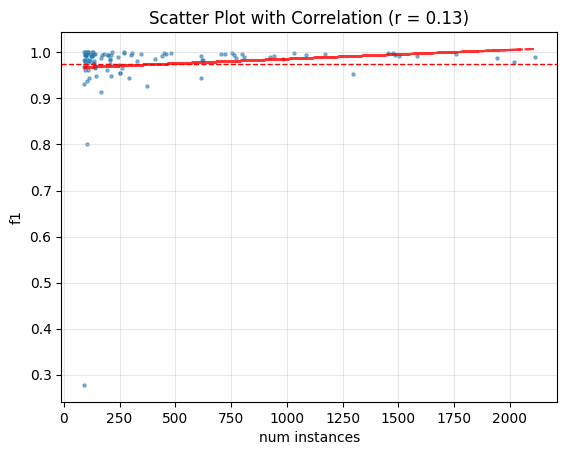

In [16]:

# plot num_positives vs f1
import matplotlib.pyplot as plt
plt.scatter(df["num_instances"], df["f1"], s=5, alpha=0.5)
# draw a line through the mean
plt.axhline(df["f1"].mean(), color='red', linestyle='dashed', linewidth=1)
z = np.polyfit(df["num_instances"], df["f1"], 1)
p = np.poly1d(z)
plt.plot(df["num_instances"], p(df["num_instances"]), "r--", alpha=0.8)
plt.xlabel('num instances')
plt.ylabel('f1')
plt.title(f'Scatter Plot with Correlation (r = {correlation:.2f})')
plt.grid(True, alpha=0.3)
plt.savefig("figures/num_instances_vs_f1.png")
plt.show()

In [17]:
from c3p.stats import calculate_metrics_pandas


def micro_stats(df):
    df["f1_score"] = df["f1"]
    return df.select_dtypes(include=['int64', 'float64']).mean()

def macro_stats(df):
    return calculate_metrics_pandas(df)

def calculate_stats(df):
    sdf = pd.DataFrame(
        {
            'micro': micro_stats(df),
            'macro': macro_stats(df),
        },
    )
    sdf = sdf.transpose()
    return sdf[["f1_score", "precision", "recall"]]
    

calculate_stats(df)

,f1_score,precision,recall
micro,0.974228,0.994915,0.961026
macro,0.986100,0.996400,0.976100


In [18]:
calculate_stats(df).to_csv(results_dir / "summary.csv")